# Problem statement

Sudden user engagement dip in August requires investigation.

# Possible causes of retention drop

1. Holiday (change of schedule)
2. Change in interface/usability
3. A new competitor has popped up
4. Change in cost of subscription
5. No new features have been added in a long time
6. Server update
7. Less signups overall 


# Digging into the data

Importing all necessary packages

In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

Connecting to the database

In [3]:
conn = sqlite3.connect('case-study.db')
c = conn.cursor()

Exploring users, events, emails data table

In [6]:
pd.read_sql('''
SELECT * FROM users
''', conn).head()

,user_id,created_at,company_id,language,activated_at,state
0,0,2013-01-01 20:59:39,5737,english,2013-01-01 21:01:07,active
1,1,2013-01-01 13:07:46,28,english,None,pending
2,2,2013-01-01 10:59:05,51,english,None,pending
3,3,2013-01-01 18:40:36,2800,german,2013-01-01 18:42:02,active
4,4,2013-01-01 14:37:51,5110,indian,2013-01-01 14:39:05,active


In [7]:
pd.read_sql('''
SELECT * FROM events
''', conn).head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3
1,10522,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3
2,10522,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3
3,10522,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3
4,10522,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3


In [12]:
pd.read_sql('''
SELECT Distinct event_type FROM events
''', conn)

,event_type
0,engagement
1,signup_flow


In [11]:
pd.read_sql('''
SELECT Distinct event_name FROM events
''', conn)

,event_name
0,login
1,home_page
2,like_message
3,view_inbox
4,search_run
5,send_message
6,search_autocomplete
7,search_click_result_10
8,create_user
9,enter_email


In [15]:
pd.read_sql('''
SELECT * FROM events
WHERE event_name='complete_signup'
''', conn).head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,11768,2014-05-01 08:03:12,signup_flow,complete_signup,France,macbook pro,3
1,11770,2014-05-01 06:08:50,signup_flow,complete_signup,Japan,iphone 5s,3
2,11775,2014-05-01 16:38:06,signup_flow,complete_signup,United Kingdom,lenovo thinkpad,2
3,11778,2014-05-01 18:49:49,signup_flow,complete_signup,Indonesia,iphone 4s,3
4,11779,2014-05-01 18:24:54,signup_flow,complete_signup,Germany,samsung galaxy s4,1


### Dive into platform signups

In [16]:
pd.read_sql('''
SELECT * FROM events
WHERE event_name='complete_signup'
''', conn).head()

,user_id,occurred_at,event_type,event_name,location,device,user_type
0,11768,2014-05-01 08:03:12,signup_flow,complete_signup,France,macbook pro,3
1,11770,2014-05-01 06:08:50,signup_flow,complete_signup,Japan,iphone 5s,3
2,11775,2014-05-01 16:38:06,signup_flow,complete_signup,United Kingdom,lenovo thinkpad,2
3,11778,2014-05-01 18:49:49,signup_flow,complete_signup,Indonesia,iphone 4s,3
4,11779,2014-05-01 18:24:54,signup_flow,complete_signup,Germany,samsung galaxy s4,1


In [46]:
signups = pd.read_sql('''
SELECT strftime('%d', occurred_at) as day,
       strftime('%m', occurred_at) as month,
       strftime('%Y', occurred_at) as year,
       strftime('%W-%Y', occurred_at) as date,
       COUNT(distinct user_id) as count
from events
WHERE event_name='complete_signup'
group by date
''', conn)

In [47]:
engagements = pd.read_sql('''
SELECT strftime('%d', occurred_at) as day,
       strftime('%m', occurred_at) as month,
       strftime('%Y', occurred_at) as year,
       strftime('%W-%Y', occurred_at) as date,
       count(distinct user_id) as count
from events
WHERE event_type='engagement'
group by date
''', conn)

In [48]:
engagements.head()

,day,month,year,date,count
0,02,05,2014,17-2014,701
1,09,05,2014,18-2014,1054
2,15,05,2014,19-2014,1094
3,20,05,2014,20-2014,1147
4,28,05,2014,21-2014,1113


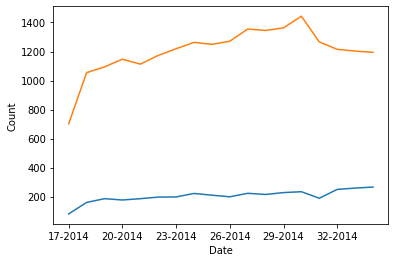

In [53]:
plt.figure()
plt.plot(signups['date'],signups['count'])
plt.plot(engagements['date'], engagements['count'])
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(signups['date'][::3])
plt.show()
